<a href="https://colab.research.google.com/github/probml/probml-notebooks/blob/main/notebooks/dirac_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## The DiracGAN example

Author: Mihaela Rosca 

We show DiracGAN (https://arxiv.org/abs/1801.04406), where the true distribution is is Dirac delta distribution with mass at zero. The generator is modeling a Dirac delta distribution with parameter $\theta$: $G_{\theta}(z) = \theta$ and the discriminator is a linear function of the input with learned
parameter $\phi$: $D_{\phi}(x) = \phi x$. This results in the zero-sum game given by:
$$ 
L_D = - l(\theta \phi) - l(0) \\
L_G = + l(\theta \phi) + l(0) 
$$

where $l$ depends on the GAN formulation used ($l(z) = - \log (1 + e^{-z})$ for instance). The unique equilibrium point is $\theta = \phi = 0$. 

In [ ]:
import numpy as np
import matplotlib.pylab as plt
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from scipy.misc import derivative
import seaborn as sns

In [ ]:
def set_up_fonts():
    sns.reset_orig()

    import matplotlib

    matplotlib.rcParams["pdf.fonttype"] = 42
    matplotlib.rcParams["ps.fonttype"] = 42

### Display variables

In [ ]:
hw = 10
hl = 6
minshaft = 2
scale = 1.5

In [ ]:
color = ["blue", "red", "green", "orange", "magenta"]

In [ ]:
set_up_fonts()

## Defining the Euler updates (gradient descent)

In [ ]:
def euler_alternating(fn, v, t):	#fn defines the ODE system ∂(L_D,L_G)=fn(t,(θ,φ)), v=initial (θ,φ), t=(step values of t)
    last_t = t[0]
    vs = [v]
    num_dims = len(v)
    last_v = list(v)
    for current_t in t[1:]:
        delta_t = current_t - last_t
        for i in range(num_dims):
            interim_v = last_v + delta_t * np.array(fn(current_t, last_v))
            last_v[i] = interim_v[i]
        last_t = current_t
        vs.append(last_v.copy())
    return np.array(vs)

In [ ]:
def euler(fn, v, t):	#simultaneous update
    last_t = t[0]
    vs = [v]
    last_v = v
    for current_t in t[1:]:
        current_v = last_v + (current_t - last_t) * np.array(fn(current_t, last_v))
        last_t = current_t
        last_v = current_v
        vs.append(current_v)
    return np.array(vs)

# Dirac GAN



In [ ]:
grad_f = lambda x: 1.0 / (1 + np.exp(-x))	#should be e^(-x)/(1+e^(-x)), but 1/( ) is equivalent to reparameterize θ or φ as -θ or -φ;

vect0 = [(1, 1)]

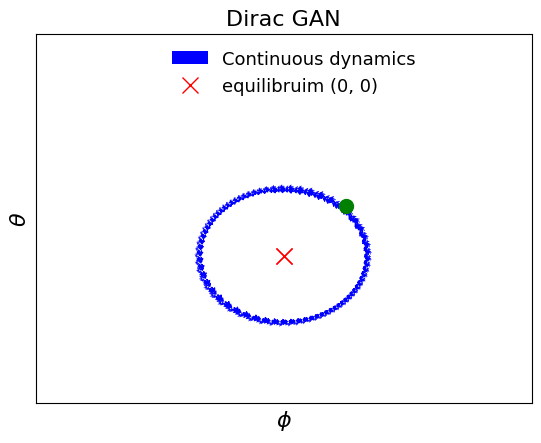

In [ ]:
# Write the problem in a way compatible with solve_ivp.
# Return the gradients for each player.
def system(t, vect):
    x, y = vect	#??? y=φ of D_φ, x=θ of G_θ, in Murphy22Adv 26.50, I haven't quite sorted this out especially now there's the reparam of θ to -θ;
    return [-grad_f(x * y) * y, grad_f(x * y) * x]


t = np.arange(0, 100, 0.2)
plot = plt.figure()
v = vect0[0]

sol = solve_ivp(system, (0, 200), v, t_eval=t, dense_output=True, method="RK45")
sol = sol.sol(t).T	#transpose
widths = np.linspace(0, 2, sol.size)
plt.quiver(
    sol[:-1, 0],
    sol[:-1, 1],
    sol[1:, 0] - sol[:-1, 0],
    sol[1:, 1] - sol[:-1, 1],
    scale_units="xy",
    angles="xy",
    scale=2,
    color=color[0],
    linewidths=widths,
    edgecolors=color[0],
    label="Continuous dynamics",
    headwidth=hw,
    headlength=hl,
    minshaft=2,
)

plt.title("Dirac GAN", fontsize=16)
plt.plot(v[0], v[1], "go", markersize=10)
plt.plot(0, 0, "rx", markersize=12)
plt.plot(0, 0, "rx", markersize=12, label="equilibruim (0, 0)")
plt.legend(loc="upper right", bbox_to_anchor=(0.8, 1), fontsize=13, framealpha=0)

plt.xlabel(r"$\phi$", fontsize=16)
plt.ylabel(r"$\theta$", fontsize=16)

plt.xticks([])
plt.yticks([])
plt.xlim((-4, 4))
plt.ylim((-3, 4.5))

plt.show()


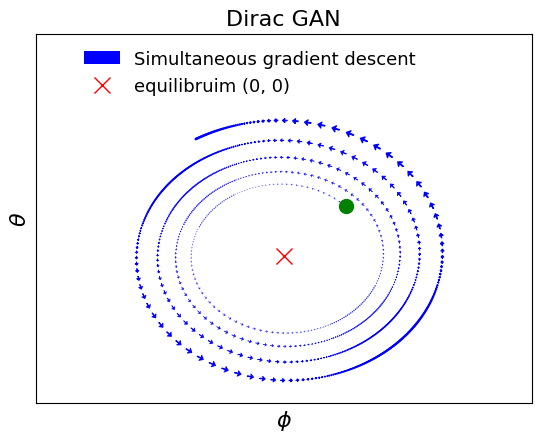

In [48]:
disc_lr = 0.1
gen_lr = 0.1
vect0 = [(1, 1)]

t = np.arange(0, 100, disc_lr)
plot = plt.figure()
v = vect0[0]


sol = euler(system, v, t)
widths = np.linspace(0, 2, sol.size)
plt.quiver(
    sol[:-1, 0],
    sol[:-1, 1],
    sol[1:, 0] - sol[:-1, 0],
    sol[1:, 1] - sol[:-1, 1],
    scale_units="xy",
    angles="xy",
    scale=2,
    color=color[0],
    linewidths=widths,
    edgecolors=color[0],
    label="Simultaneous gradient descent",
    headwidth=hw,
    headlength=hl,
    minshaft=2,
)

plt.title("Dirac GAN", fontsize=16)
plt.plot(v[0], v[1], "go", markersize=10)
plt.plot(0, 0, "rx", markersize=12, label="equilibruim (0, 0)")
plt.legend(loc="upper right", bbox_to_anchor=(0.8, 1), fontsize=13, framealpha=0)

plt.xlabel(r"$\phi$", fontsize=16)
plt.ylabel(r"$\theta$", fontsize=16)
plt.xticks([])
plt.yticks([])
plt.xlim((-4, 4))
plt.ylim((-3, 4.5))

plt.show()

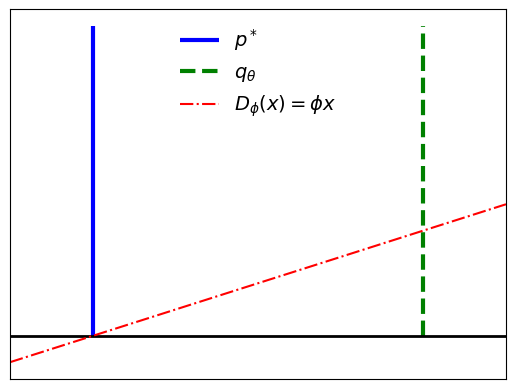

In [49]:
plt.vlines(0, 0, 10, lw=3, colors="b", label=r"$p^*$")
plt.vlines(2, 0, 10, lw=3, colors="g", label=r"$q_{\theta}$", linestyles="--")
plt.hlines(0, -1, 10, lw=2, colors="k")

xlim = np.linspace(-0.5, 2.5, 50)
plt.plot(xlim, 1.7 * xlim, color="r", label=r"$D_{\phi}(x) = \phi x$", ls="-.")

plt.xlim(-0.5, 2.5)
plt.yticks([])
plt.xticks([])
plt.legend(framealpha=0, loc="upper center", fontsize=14)
plt.show()

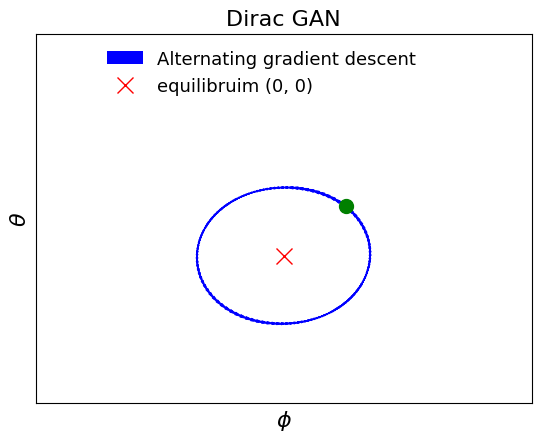

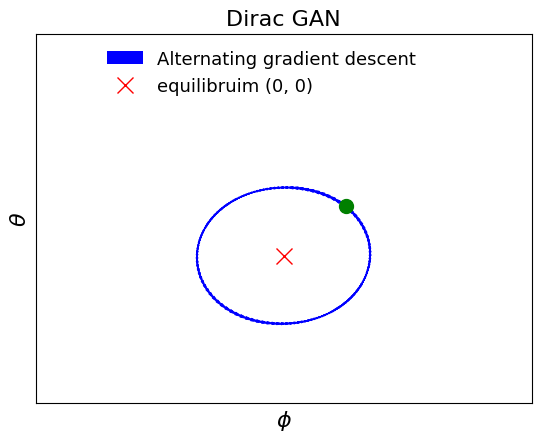

In [51]:
lr = 0.1
vect0 = [(1, 1)]

t = np.arange(0, 100, lr)
plot = plt.figure()
v = vect0[0]

sol = euler_alternating(system, v, t)
widths = np.linspace(0, 2, sol.size)
plt.quiver(
    sol[:-1, 0],
    sol[:-1, 1],
    sol[1:, 0] - sol[:-1, 0],
    sol[1:, 1] - sol[:-1, 1],
    scale_units="xy",
    angles="xy",
    scale=2,
    color=color[0],
    linewidths=widths,
    edgecolors=color[0],
    label="Alternating gradient descent",
    headwidth=hw,
    headlength=hl,
    minshaft=2,
)

plt.title("Dirac GAN", fontsize=16)
plt.plot(v[0], v[1], "go", markersize=10)
plt.plot(0, 0, "rx", markersize=12, label="equilibruim (0, 0)")
plt.legend(loc="upper right", bbox_to_anchor=(0.8, 1), fontsize=13, framealpha=0)

plt.xlabel(r"$\phi$", fontsize=16)
plt.ylabel(r"$\theta$", fontsize=16)

plt.xticks([])
plt.yticks([])
plt.xlim((-4, 4))
plt.ylim((-3, 4.5))

plt.show()